In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

from joblib import Parallel, delayed
import time

WAV_FILE_PATH = '../../data/input/waveforms.root'
DATASET_PATH = '../../data/transformed_input/dataset.pkl'

import uproot
import pickle

import numpy as np
from matplotlib import pyplot as plt

from src.cfd import CFD
from src.waveform_data import EventData, WaveformData

# Load file

In [2]:
N_JOBS = 8

In [3]:
SECTOR = 'sector 56'
STATION = 'station 220cyl'
RP = 'cyl_hr'

data_dir = f'wav/CTPPS/TimingDiamond/{SECTOR}/{STATION}/{RP}'

In [4]:
file_raw = uproot.open(WAV_FILE_PATH)

len(file_raw[data_dir].keys(recursive=False))

120017

In [5]:
sorted_events = sorted(file_raw[data_dir].keys(recursive=False), key=lambda x: int(x[6:-2]))
sorted_events[:10]

['event 3375;1',
 'event 6341;1',
 'event 7535;1',
 'event 8570;1',
 'event 9831;1',
 'event 9900;1',
 'event 10650;1',
 'event 11542;1',
 'event 13050;1',
 'event 14400;1']

# Transform the dataset

In [6]:
def find_slices(length, n):
    interval = length // n
    slices = [i * interval for i in range(n)] + [length]
    return slices

def transform_event_collection(file_raw, data_dir, events):
    dataset = []
    for event in events:
        event_int = int(event[6:-2])
        event_data = file_raw[data_dir][event]
        dataset.append((event_int, EventData.from_event_data(event_data)))
    return dataset

start = time.time()
slices = find_slices(len(sorted_events), N_JOBS)
dataset = Parallel(n_jobs=N_JOBS)(delayed(transform_event_collection)(file_raw, data_dir, sorted_events[slices[i]:slices[i+1]]) for i in range(len(slices) - 1))
dataset = dict(sum(dataset, []))
end = time.time()
print(f'Elapsed time: {end - start:0.2f} s')

# store the dataset
with open(DATASET_PATH, 'wb') as file:
    pickle.dump(dataset, file)

Elapsed time: 86.49 s


In [7]:
# load the dataset
with open(DATASET_PATH, 'rb') as file:
    original_dataset = pickle.load(file)

In [8]:
print(original_dataset[3375])

{'plane 1': {'channel 11': 't0: -8.286604881286621'}, 'plane 2': {'channel 11': 't0: 0.12372398376464844'}, 'plane 3': {'channel 11': 't0: -5.702384948730469'}}


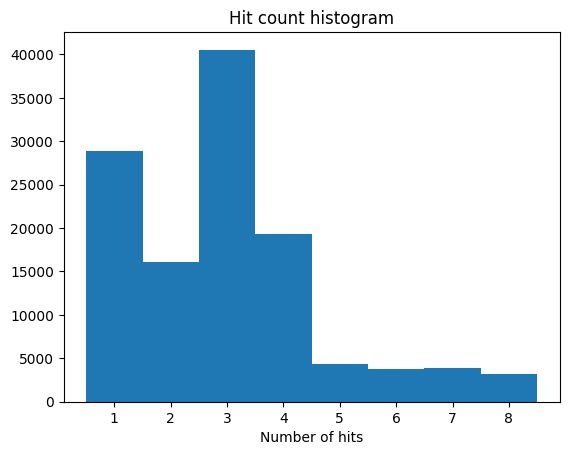

In [9]:
def plot_hit_count_histogram(dataset, title='Hit count histogram'):
    hit_count_histogram = [event_data.get_hit_count() for event_data in dataset.values()]

    plt.hist(hit_count_histogram, bins=range(1, 8 + 2), align='left')
    plt.title(title)
    plt.xlabel('Number of hits')
    
plot_hit_count_histogram(original_dataset)
plt.show()

In [10]:
file_raw.close()